# Titanic Regression

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Construcción de una funcion que realice el particionado completo
def train_val_test_split(df,rstate = 42,shuffle = True, stratify = None):
    strat = df[stratify] if stratify else None
    train_set,test_set = train_test_split(
              df, test_size = 0.2, random_state = rstate, shuffle = shuffle, stratify = strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
    test_set, test_size =0.5, random_state = rstate, shuffle = shuffle, stratify = strat)
    
    return (train_set, val_set, test_set)

In [3]:
#Transformador que prepara todo el conjunto de datos llamados Pipelines y tranformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y = None):
        num_attribs = list(X.select_dtypes(exclude = ['object']))
        cat_attribs = list(X.select_dtypes(include = ['object']))
        self._full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
    def transform(self, X, y = None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep,
                           columns = self._columns,
                           index = X_copy. index)

In [4]:
#Transformador para codificar unicamente las columnas categoricas y devolver una DataFrame
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse = False)
        self._columns = None
    def fit(self, X, y = None):
        X_cat = X.select_dtypes(include = ['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y = None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include = ['object'])
        X_num = X_copy.select_dtypes(exclude = ['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh,
                               columns = self._columns,
                               index = X_copy.index)
        X_copy.drop(list(X_cat), axis = 1, inplace = True)
        return X_copy.join(X_cat_oh)

In [5]:
# Construcción de un Pipeline para los atributos numericos
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('rbst_scaler', RobustScaler()),
])

In [6]:
def load_kdd_dataset(data_path):
    #Sirve para hacer cometarios multilinea
        """Lectura del DataSet NSL-KDD."""
        with open(data_path, 'r') as train_set:
            dataset = arff.load(train_set)
        attributes = [attr[0] for attr in dataset["attributes"]]
        return pd.DataFrame(dataset["data"], columns = attributes)

In [7]:
# Read dataset
# Lectura del DataSet utilizando Pandas
import pandas as pd
import numpy as np
import seaborn as sns 
import arff 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

titanic = load_kdd_dataset("Data2/data2.arff")
titanic

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C,None,328.0,None
1305,3.0,0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C,None,NaN,None
1306,3.0,0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C,None,304.0,None
1307,3.0,0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C,None,NaN,None


In [8]:
print("Titanic Size  :" ,titanic.size)
print("Titanic Shape :" ,titanic.shape)

Titanic Size  : 18326
Titanic Shape : (1309, 14)


In [9]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   float64
 1   survived   1309 non-null   object 
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   float64
 6   parch      1309 non-null   float64
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(6), object(8)
memory usage: 143.3+ KB


## Preprocessing

In [10]:
(titanic.isnull() | titanic.empty | titanic.isna()).sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [11]:
def showPercentageNan(colName, dtFrame):
    perc = (dtFrame[colName].isnull().sum() / dtFrame.shape[0])
    print(f"Percent of missing ''{colName}'' records is {round(perc * 100,3)} %")

In [12]:
colNan = [ 
    "fare",
    "cabin",
    "embarked",
    "boat",
    "body",
    "home.dest"
]

for col in colNan:
    showPercentageNan(col, titanic)

Percent of missing ''fare'' records is 0.076 %
Percent of missing ''cabin'' records is 77.464 %
Percent of missing ''embarked'' records is 0.153 %
Percent of missing ''boat'' records is 62.872 %
Percent of missing ''body'' records is 90.756 %
Percent of missing ''home.dest'' records is 43.086 %


In [13]:
titanic.drop(["cabin","boat","body","home.dest"], axis=1, inplace=True)

In [14]:
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,S
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,S
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,S
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,S
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,S


In [15]:
titanic["fare"].fillna(value = titanic["fare"].mean(), inplace=True)
titanic["embarked"].fillna(titanic["embarked"].value_counts().idxmax(), inplace=True)
titanic["age"].fillna(value = titanic["age"].mean(), inplace=True)

In [16]:
nrAgeNaN = titanic["age"].isna().sum()
nrFareNaN = titanic["fare"].isna().sum()
nrEmbarkedNaN = titanic["embarked"].isna().sum()
print(f"Now we have {nrAgeNaN} missing values on age column!")
print(f"Now we have {nrFareNaN} missing values on fare column!")
print(f"Now we have {nrEmbarkedNaN} missing values on embarked column!")

Now we have 0 missing values on age column!
Now we have 0 missing values on fare column!
Now we have 0 missing values on embarked column!


In [17]:
from sklearn.preprocessing import LabelEncoder

labelencoder_X = LabelEncoder()

titanic["name"] = labelencoder_X.fit_transform(titanic["name"])
titanic["embarked"] = labelencoder_X.fit_transform(titanic["embarked"])
titanic["ticket"] = titanic["ticket"].astype(str)
titanic["ticket"] = labelencoder_X.fit_transform(titanic["ticket"])

In [18]:
from sklearn.preprocessing import OneHotEncoder

result = OneHotEncoder().fit_transform(titanic["sex"].values.reshape(-1, 1)).toarray()
titanic[["Female", "Male"]] = pd.DataFrame(result, index = titanic.index)
titanic.drop(["sex"], axis=1, inplace=True)

## Train and Test

In [19]:
# División del DataSet en os diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(titanic)

In [20]:
print("Longitud del TRaining Set", len(train_set))
print("Longitud del Validation Set", len(val_set))
print("Longitud del Test Set", len(test_set))

Longitud del TRaining Set 1047
Longitud del Validation Set 131
Longitud del Test Set 131


In [21]:
# Conjunto de datos General
X_df = titanic.drop("survived", axis = 1)
y_df = titanic['survived'].copy()

In [22]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("survived", axis =1)
y_train = train_set['survived'].copy()

In [23]:
# Conjunto de datos de validación
x_val = val_set.drop("survived", axis =1)
y_val = val_set["survived"].copy()

In [24]:
# Conjunto de pruebas
X_test = test_set.drop("survived", axis =1)
y_test = test_set["survived"].copy()

## Preparación del DataSet

In [25]:
# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

In [26]:
# Hacer el ajuste (fit) con el DataSet general para que adquiera
# todos los valores posibles
data_preparer.fit(X_df)

DataFramePreparer()

In [27]:
# TRansformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)
X_train.head(10)

,pclass,name,age,sibsp,parch,ticket,fare,embarked,Female,Male
772,3.0,329,17.000000,0.0,0.0,515,7.8958,2,0.0,1.0
543,2.0,984,36.000000,0.0,0.0,748,10.5000,2,0.0,1.0
289,1.0,1165,18.000000,0.0,2.0,1,79.6500,2,1.0,0.0
10,1.0,68,47.000000,1.0,0.0,833,227.5250,0,0.0,1.0
147,1.0,502,29.881135,0.0,0.0,61,42.4000,2,0.0,1.0
348,2.0,148,27.000000,0.0,0.0,136,13.0000,2,0.0,1.0
983,3.0,734,29.881135,0.0,0.0,770,7.5500,2,0.0,1.0
825,3.0,455,9.000000,5.0,2.0,775,46.9000,2,0.0,1.0
350,2.0,160,15.000000,0.0,2.0,325,39.0000,2,1.0,0.0
900,3.0,606,29.881135,1.0,2.0,923,23.4500,2,0.0,1.0


In [28]:
X_train_prep.head(5)

,pclass,name,age,sibsp,parch,ticket,fare,embarked,Female,Male
772,0.0,-0.494640,-0.990857,0.0,0.0,0.108738,-0.280523,0.0,0.0,0.0
543,-1.0,0.508423,0.470682,0.0,0.0,0.561165,-0.169133,0.0,0.0,0.0
289,-2.0,0.785605,-0.913933,0.0,2.0,-0.889320,2.788624,0.0,1.0,-1.0
10,-2.0,-0.894334,1.316836,1.0,0.0,0.726214,9.113691,-2.0,0.0,0.0
147,-2.0,-0.229709,0.000000,0.0,0.0,-0.772816,1.195327,0.0,0.0,0.0


In [29]:
# Transformar el subconjunto de datos de validación
X_val_prep = data_preparer.transform(x_val)

In [30]:
X_val_prep.head(10)

,pclass,name,age,sibsp,parch,ticket,fare,embarked,Female,Male
1234,0.0,0.773354,-0.375472,0.0,0.0,0.838835,-0.316700,0.0,0.0,0.0
1148,0.0,0.540582,0.393759,0.0,0.0,0.854369,-0.313492,0.0,0.0,0.0
527,-1.0,0.418070,-0.144703,0.0,0.0,0.761165,-0.169133,0.0,0.0,0.0
243,-2.0,0.568147,1.239913,0.0,0.0,0.673786,2.769376,-2.0,0.0,0.0
1242,0.0,0.803982,0.000000,0.0,0.0,-0.355340,-0.342899,-2.0,0.0,0.0
630,0.0,-0.938744,-0.221626,0.0,0.0,0.182524,-0.284800,0.0,0.0,0.0
316,-2.0,0.946401,1.624528,0.0,1.0,0.689320,2.007126,-2.0,0.0,0.0
208,-2.0,0.228178,0.547605,1.0,0.0,-0.658252,3.231325,-1.0,1.0,-1.0
613,0.0,-0.975498,-0.298549,0.0,0.0,-0.320388,0.185349,-2.0,0.0,0.0
1094,0.0,0.387443,0.086067,0.0,0.0,0.132039,-0.246839,0.0,1.0,-1.0


# Entrenamieneto

In [31]:
# Entrenamos un algoritmo basado en regresión logistica.
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 5000)
clf.fit(X_train_prep, y_train)

LogisticRegression(max_iter=5000)

In [32]:
y_pred = clf.predict(X_val_prep)

## 1.- Matriz de Confusión.

In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val,y_pred)

array([[64,  8],
       [22, 37]])

/home/suseth/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


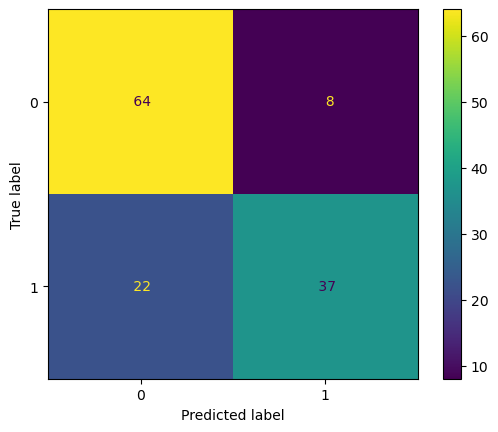

In [34]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val_prep, y_val, values_format = '3g')

## 2.- Métricas derivadas de la matriz de confusión.

### Precisión.

In [35]:
from sklearn.metrics import precision_score

print("Precisión: ", precision_score(y_val, y_pred, pos_label = '0'))
## Nivel de precisión de los datos que se dieron con los que se predijeron

Precisión:  0.7441860465116279


### Recall.

In [36]:
from sklearn.metrics import recall_score

print("Recall: ", recall_score(y_val, y_pred, pos_label = '0'))
## Nivel de predicción en los datos que dieron positivos

Recall:  0.8888888888888888


### F1 Score.

In [37]:
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(y_val, y_pred, pos_label= '0'))
# Se calcula en base a la precision y al recall

F1 Score:  0.8101265822784809
